# Numer.ai

We look into the [numer.ai](https://numer.ai/) data challenge using sklean. Thanks to [Zygmunt Zając](https://github.com/zygmuntz/numer.ai) for posting examples.

In [1]:
import pandas as pd
from time import clock

We first need to load the data. We drop the validation flag for the prediction.

In [2]:
train_file = 'dataset/numerai_training_data.csv'
test_file = 'dataset/numerai_tournament_data.csv'
predict_file = 'predict.csv'

start = clock()
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
print('Loaded {:d} train and {:d} test entries in {:.0f} seconds.'.format( 
    len(train_data), len(test_data), clock() - start))

# No need for validation flag for final training and extrapolation
train_data.drop('validation', axis = 1 , inplace = True)

# Separate data and target label
train_target = train_data['target']
train_data.drop('target', axis = 1, inplace = True)

Loaded 55038 train and 19461 test entries in 0 seconds.


There is one categorial variable. We use one-hot encoding to deal with it.

In [3]:
# Check train and test have the same categories
assert(set(train_data['c1'].unique()) == set(test_data['c1'].unique()))

# Encode column in train, then drop original column
train_dummies = pd.get_dummies(train_data['c1'])
train_data = pd.concat((train_data.drop('c1', axis = 1), train_dummies.astype(int)), axis = 1)

# Encode column in test, then drop original column
test_dummies = pd.get_dummies(test_data['c1'])
test_data = pd.concat((test_data.drop('c1', axis = 1), test_dummies.astype(int)), axis = 1)

We can use ggplot to visualize the data, and obverse the structure.

/home/vincent/.local/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/vincent/.local/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/vincent/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


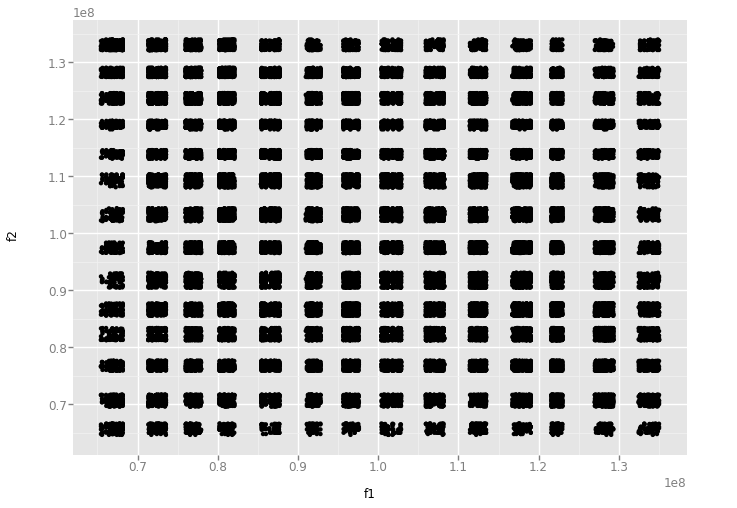

<ggplot: (-9223363245822653075)>


In [4]:
from ggplot import ggplot, aes, geom_point
%pylab inline

f1f2 = ggplot(train_data, aes(x = 'f1', y = 'f2')) \
       + geom_point()

print(f1f2)

<img src="dataset_f1f2.png">

# Prediction
We simply now have to select a classifier. Random forest does fine, and so does preprocessed logistic regression.

In [5]:
# Random forest

from sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators = 1000, verbose = True)

In [6]:
# Logistic regression with preprocessor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression as LR

# clf = make_pipeline([MinMaxScaler(), LR()])

We simply now have to train, extrapolate, and save.

In [7]:
# Fit training data

start = clock()
clf.fit(train_data, train_target)
print("Fitted in {:.0f} seconds.".format(clock() - start))

Fitted in 219 seconds.


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  3.7min finished


In [8]:
# Extrapolate

start = clock()
# Don't forget to ignore the t_id column!
predict = clf.predict_proba(test_data.drop('t_id', axis = 1, inplace = False))
print("Extrapolated in {:.0f} seconds.".format(clock() - start))

# Save results

test_data['probability'] = predict[:,1]
test_data.to_csv(predict_file, columns = ('t_id', 'probability'), index = None)

Extrapolated in 18 seconds.


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   18.1s finished


The scores are measured using the ROC AUC. As of February 2016,
- RF does 0.5218;
- MMS+LR does 0.5278.